**IMPORTANT LEARNINGS: Related to AI Agents**
```
# ⚡ REAL MAGIC LIES in the ***prompting, Consoling, Error Understanding***
```

---



1.   REAL MAGIC lies in the prompting (That has to be explained very very very clearly, if possible use examples)
2.   Console where ever you feeling something is wrong
3. Understand the error properly and take further steps to resolve












In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display , Image
from langchain.tools import tool
import json

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
class State(TypedDict):
  question: str
  subject_category: str
  course_name: str
  required_personal_suppport: str
  answer: str

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)
result = llm.invoke("What is langchain")
result.content

'LangChain is an open-source framework designed to help developers build applications that utilize large language models (LLMs) more efficiently. It was created to simplify the process of integrating LLMs into various projects, making it easier for developers to leverage the capabilities of these powerful models.\n\nLangChain provides a set of tools and libraries that enable developers to:\n\n1. **Interact with LLMs**: LangChain offers a unified interface to interact with different LLMs, such as LLaMA, PaLM, and others, allowing developers to write code that works across multiple models.\n2. **Manage memory and caching**: LangChain includes features to manage memory and caching, which helps to reduce the computational resources required to run LLMs and improves overall performance.\n3. **Implement indexing and retrieval**: LangChain provides tools for indexing and retrieving information from LLMs, making it easier to build applications that require searching, filtering, or ranking of r

In [ ]:
def subject_wise_category(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following student question into one of these categories:"
        "Language, About a course. If the question is related to language then retrun category called 'Language'. If any question is related to the courses like javascript, python, angular, Data Science, Gen Ai, then please return the category like 'About a course''"
        "here is the question of the student Question: {question}"
    )

    chain = prompt | llm
    response = chain.invoke({"question": state["question"]}).content
    return {"subject_category": response}

In [ ]:
def required_personal_support(state: State) -> State:
  prompt = ChatPromptTemplate.from_template(
      "Check if student required any personal support or any personal assistant to answer his question"
      "Response with either 'Required personal assistant', or 'he doesnt want any personal assistant'. Question: {question}"
  )
  chain = prompt | llm
  required_personal_suppport = chain.invoke({"question": state["question"]}).content
  return {"required_personal_suppport": required_personal_suppport}

In [ ]:
def get_course_amount(state: State) -> State:
    """
    To get the amount of a course, it takes course_name as question and return amount.
    """
    course_prices = {
        "Javascript": 5000,
        "Python": 8000,
        "Angular": 3000,
        "Data Science": 10000,
        "Gen AI": 20000,
    }

    prompt = ChatPromptTemplate.from_template(
        "If the question contains any course name, then please return that course name. Example: If user has asked a question like may I know the cost of the 'Reactjs' course, then from question pick the 'Reactjs' and return the 'Reactjs' as a response"
        "Please do not return the response as like Reactjs Course, return the rsponse only with the course name like Reactjs"
        "here is the question of the student Question: {question}"
    )

    chain = prompt | llm
    response = chain.invoke({"question": state["question"]}).content
    print('response_course name', response)
    course_amount = course_prices.get(response, "Course not found")
    print('course_amount', course_amount)
    return {"answer": course_amount}


In [ ]:
def provide_support(state: State)->State:
  return {"answer": "Teacher will contact you"}

In [ ]:
def language_related_questions(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide the support related to languages as per to question : {question}"
  )
  chain = prompt | llm
  answer = chain.invoke({"question": state["question"]}).content
  return {"answer": answer}

In [ ]:
def route_as_per_question(state: State) -> str:
  if 'About a course' in state["subject_category"]:
     return "get_course_amount"
  elif 'Language' in state["subject_category"]:
    return "language_related_questions"
  else:
    return "provide_support"

In [ ]:
graph = StateGraph(State)

graph.add_node("subject_wise_category", subject_wise_category)
graph.add_node("required_personal_support", required_personal_support)
graph.add_node("language_related_questions", language_related_questions)
graph.add_node("get_course_amount", get_course_amount)
graph.add_node("provide_support", provide_support)

graph.add_edge("subject_wise_category", "required_personal_support")
graph.add_conditional_edges(
    "required_personal_support",
    route_as_per_question,{
        "provide_support" : "provide_support",
        "language_related_questions" :  "language_related_questions",
        "get_course_amount" : "get_course_amount"
    }
)

graph.add_edge("provide_support", END)
graph.add_edge("language_related_questions", END)
graph.add_edge("get_course_amount", END)

graph.set_entry_point("subject_wise_category")

app  = graph.compile()

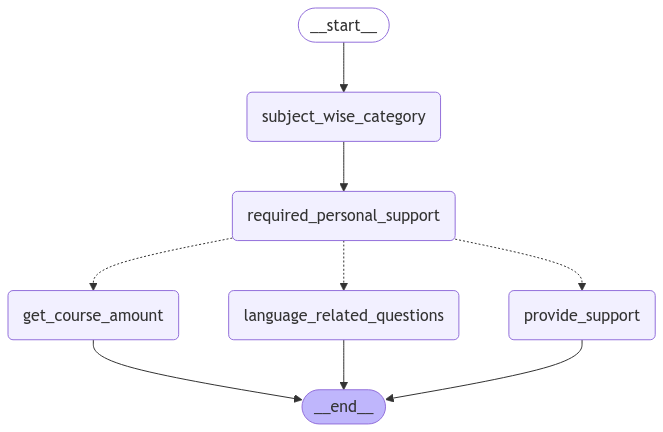

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png()))

In [ ]:
question = "I have lot many doubt I want some one to support me please"
app.invoke({"question": question})

{'question': 'I have lot many doubt I want some one to support me please',
 'subject_category': "Based on the student's question, I would categorize it as 'Language' because the question seems to be related to a request for support or guidance, and the language used is not specific to any particular course. The student is expressing a general need for help, rather than asking a question about a specific course like JavaScript, Python, or Data Science. \n\nCategory: Language",
 'required_personal_suppport': 'Required personal assistant',
 'answer': "I'm here to support you with any language-related doubts or questions you may have. Please feel free to ask me anything, and I'll do my best to help. \n\nHere are some areas where I can provide support:\n\n1. **Language Learning**: If you're learning a new language, I can help with grammar, vocabulary, pronunciation, and sentence structure.\n2. **Language Translation**: If you need help translating text from one language to another, I can as